# Automated Feature Engineering Basics

In [1]:
# !pip install featuretools

In [76]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('downloads/application_train.csv/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
app_test = pd.read_csv('downloads/application_test.csv/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv('downloads/bureau.csv/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv('downloads/bureau_balance.csv/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]
cash = pd.read_csv('downloads/POS_CASH_balance.csv/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
credit = pd.read_csv('downloads/credit_card_balance.csv/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
previous = pd.read_csv('downloads/previous_application.csv/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
installments = pd.read_csv('downloads/installments_payments.csv/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]

In [8]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

In [9]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [11]:
# Entities with a unique index
es = es.add_dataframe(dataframe_name='app',dataframe=app,index='SK_ID_CURR')
es = es.add_dataframe(dataframe_name = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.add_dataframe(dataframe_name = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name='bureau_balance',dataframe=bureau_balance,make_index=True,index='bureaubalance_index')
es = es.add_dataframe(dataframe_name = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.add_dataframe(dataframe_name = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.add_dataframe(dataframe_name = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

In [12]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

         FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20
100002                 0                 0                 0                 0
100003                 0                 0                 0                 0
100004                 0                 0                 0                 0
100006                 0                 0                 0                 0
100007                 0                 0                 0                 0

Child: bureau, Child Variable: SK_ID_CURR

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
6158905      100002       6158905        Closed      currency 1
6158906      100002       6158906        Closed      currency 1
6158907      100002       6158907        Closed      currency 1
6158908      100002       6158908        Closed      currency 1
6158909      100002       6158909        Active      currency 1


In [18]:
# Relationship between app and bureau
r_app_bureau = es.add_relationship('app','SK_ID_CURR','bureau','SK_ID_CURR')
# Relationship between bureau and bureau balance
r_bureau_balance = es.add_relationship('bureau','SK_ID_BUREAU', 'bureau_balance','SK_ID_BUREAU')

# Relationship between current app and previous apps
r_app_previous = es.add_relationship('app','SK_ID_CURR', 'previous','SK_ID_CURR')

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = es.add_relationship('previous','SK_ID_PREV','cash', 'SK_ID_PREV')
r_previous_installments = es.add_relationship('previous','SK_ID_PREV', 'installments','SK_ID_PREV')
r_previous_credit = es.add_relationship('previous','SK_ID_PREV', 'credit','SK_ID_PREV')

In [20]:
# Print out the EntitySet
es

Entityset: clients
  DataFrames:
    app [Rows: 2002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [27]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives["type"] == "transform"].head(10)

name       type  dask_compatible  spark_compatible  \
22          url_to_protocol  transform            False             False   
23                     week  transform             True              True   
24                less_than  transform             True              True   
25                 absolute  transform             True              True   
26               is_weekend  transform             True              True   
27           divide_numeric  transform             True              True   
28  multiply_numeric_scalar  transform             True              True   
29              numeric_lag  transform            False             False   
30      time_since_previous  transform            False             False   
31                  cum_sum  transform            False             False   

                                                     description  \
22             Determines the protocol (http or https) of a url.   
23              Determines the week of the year from a datetime.   
24  Determines if values in one list are less than another list.   
25                      Computes the absolute value of a number.   
26                      Determines if a date falls on a weekend.   
27                           Element-wise division of two lists.   
28                Multiply each element in the list by a scalar.   
29   Shifts an array of values by a specified number of periods.   
30          Compute the time since the previous entry in a list.   
31                                Calculates the cumulative sum.   

                                                                                           valid_inputs  \
22                                                                  <ColumnSchema (Logical Type = URL)>   
23                                                             <ColumnSchema (Logical Type = Datetime)>   
24  <ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnS...   
25                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
26                                                             <ColumnSchema (Logical Type = Datetime)>   
27                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
28                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
29        <ColumnSchema (Semantic Tags = ['time_index'])>, <ColumnSchema (Semantic Tags = ['numeric'])>   
30                            <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
31                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   

   return_type  
22        None  
23        None  
24        None  
25        None  
26        None  
27        None  
28        None  
29        None  
30        None  
31        None

In [38]:
data = [val for val in primitives['name'] if "char" in val]
data

['num_characters']

In [39]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]
# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)
print('%d Total Features' % len(feature_names))

2213 Total Features


In [40]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 2213 features
Elapsed: 00:21 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [41]:
feature_names[-20:]

[<Feature: STD(credit.previous.SELLERPLACE_AREA)>,
 <Feature: SUM(credit.previous.AMT_ANNUITY)>,
 <Feature: SUM(credit.previous.AMT_APPLICATION)>,
 <Feature: SUM(credit.previous.AMT_CREDIT)>,
 <Feature: SUM(credit.previous.AMT_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.AMT_GOODS_PRICE)>,
 <Feature: SUM(credit.previous.CNT_PAYMENT)>,
 <Feature: SUM(credit.previous.DAYS_DECISION)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DRAWING)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION)>,
 <Feature: SUM(credit.previous.DAYS_TERMINATION)>,
 <Feature: SUM(credit.previous.HOUR_APPR_PROCESS_START)>,
 <Feature: SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)>,
 <Feature: SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY)>,
 <Feature: SUM(credit.previous.RATE_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIMARY)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIVILEGED)>,
 <Feature:

In [42]:
# Specify the aggregation primitives
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_dataframe_name = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 1211 features
Elapsed: 00:05 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [43]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [45]:
correlations = pd.read_csv('downloads/correlations_spec.csv/correlations_spec.csv', index_col = 0)
correlations.index.name = 'Variable'
correlations.head()

SK_ID_CURR  FLAG_EMP_PHONE  \
Variable                                                  
SK_ID_CURR                     1.000000       -0.001337   
FLAG_EMP_PHONE                -0.001337        1.000000   
DEF_60_CNT_SOCIAL_CIRCLE       0.001187       -0.014034   
LIVE_REGION_NOT_WORK_REGION    0.002903        0.096447   
YEARS_BEGINEXPLUATATION_AVG    0.001551       -0.008672   

                             DEF_60_CNT_SOCIAL_CIRCLE  \
Variable                                                
SK_ID_CURR                                   0.001187   
FLAG_EMP_PHONE                              -0.014034   
DEF_60_CNT_SOCIAL_CIRCLE                     1.000000   
LIVE_REGION_NOT_WORK_REGION                 -0.016693   
YEARS_BEGINEXPLUATATION_AVG                 -0.004751   

                             LIVE_REGION_NOT_WORK_REGION  \
Variable                                                   
SK_ID_CURR                                      0.002903   
FLAG_EMP_PHONE                                  0.096447   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.016693   
LIVE_REGION_NOT_WORK_REGION                     1.000000   
YEARS_BEGINEXPLUATATION_AVG                     0.012031   

                             YEARS_BEGINEXPLUATATION_AVG  APARTMENTS_MODE  \
Variable                                                                    
SK_ID_CURR                                      0.001551         0.001961   
FLAG_EMP_PHONE                                 -0.008672         0.014720   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.004751        -0.015337   
LIVE_REGION_NOT_WORK_REGION                     0.012031         0.017831   
YEARS_BEGINEXPLUATATION_AVG                     1.000000         0.100665   

                             FLAG_MOBIL  FLOORSMIN_MEDI  BASEMENTAREA_AVG  \
Variable                                                                    
SK_ID_CURR                     0.002804        0.002837         -0.002070   
FLAG_EMP_PHONE                -0.000845        0.016486          0.001292   
DEF_60_CNT_SOCIAL_CIRCLE       0.000499       -0.020663         -0.012925   
LIVE_REGION_NOT_WORK_REGION    0.000371        0.053927          0.000965   
YEARS_BEGINEXPLUATATION_AVG   -0.000649        0.166756          0.085950   

                             LANDAREA_MODE  FLAG_DOCUMENT_21  AMT_GOODS_PRICE  \
Variable                                                                        
SK_ID_CURR                        0.001548          0.000282        -0.000232   
FLAG_EMP_PHONE                    0.008657          0.008579         0.063487   
DEF_60_CNT_SOCIAL_CIRCLE         -0.002882          0.000393        -0.024506   
LIVE_REGION_NOT_WORK_REGION      -0.006717         -0.001969         0.052864   
YEARS_BEGINEXPLUATATION_AVG       0.070008         -0.000052         0.007245   

                             COMMONAREA_MODE  APARTMENTS_MEDI  EXT_SOURCE_1  \
Variable                                                                      
SK_ID_CURR                         -0.001058         0.001988      0.000082   
FLAG_EMP_PHONE                      0.013112         0.016323     -0.294147   
DEF_60_CNT_SOCIAL_CIRCLE           -0.012114        -0.015995     -0.030508   
LIVE_REGION_NOT_WORK_REGION         0.028017         0.018141     -0.031389   
YEARS_BEGINEXPLUATATION_AVG         0.086286         0.100132      0.002120   

                             EXT_SOURCE_3  FLAG_DOCUMENT_16  \
Variable                                                      
SK_ID_CURR                       0.000222         -0.000724   
FLAG_EMP_PHONE                  -0.115293          0.043008   
DEF_60_CNT_SOCIAL_CIRCLE        -0.034096         -0.005927   
LIVE_REGION_NOT_WORK_REGION     -0.029603          0.004296   
YEARS_BEGINEXPLUATATION_AVG     -0.000406         -0.000992   

                             LIVINGAPARTMENTS_MODE  ENTRANCES_MEDI  \
Variable                                                             
SK_ID_CURR

In [46]:
correlations_target = correlations.sort_values('TARGET')['TARGET']
# Most negative correlations
correlations_target.head()

Variable
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed      -0.070201
NAME_EDUCATION_TYPE_Higher education   -0.056593
Name: TARGET, dtype: float64

In [48]:
# Most positive correlations
correlations_target.dropna().tail()

Variable
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, dtype: float64

In [49]:
features_sample = pd.read_csv('downloads/feature_matrix.csv/feature_matrix.csv', nrows = 20000)
features_sample = features_sample[features_sample['set'] == 'train']
features_sample.head()

SK_ID_CURR NAME_TYPE_SUITE  REG_REGION_NOT_LIVE_REGION  EXT_SOURCE_2  \
1      100002   Unaccompanied                           0      0.262949   
2      100003          Family                           0      0.622246   
3      100004   Unaccompanied                           0      0.555912   
5      100006   Unaccompanied                           0      0.650442   
6      100007   Unaccompanied                           0      0.322738   

  OCCUPATION_TYPE  FLAG_PHONE  AMT_INCOME_TOTAL  AMT_CREDIT  \
1        Laborers           1          202500.0    406597.5   
2      Core staff           1          270000.0   1293502.5   
3        Laborers           1           67500.0    135000.0   
5        Laborers           0          135000.0    312682.5   
6      Core staff           0          121500.0    513000.0   

   REGION_RATING_CLIENT  REG_REGION_NOT_WORK_REGION  CNT_FAM_MEMBERS  \
1                     2                           0              1.0   
2                     1                           0              2.0   
3                     2                           0              1.0   
5                     2                           0              2.0   
6                     2                           0              1.0   

   DAYS_BIRTH  REG_CITY_NOT_LIVE_CITY  COMMONAREA_AVG  FLAG_WORK_PHONE  \
1       -9461                       0          0.0143                0   
2      -16765                       0          0.0605                0   
3      -19046                       0             NaN                1   
5      -19005                       0             NaN                0   
6      -19932                       0             NaN                0   

   HOUSETYPE_MODE  FLAG_DOCUMENT_21  ELEVATORS_AVG  LIVINGAPARTMENTS_MODE  \
1  block of flats                 0           0.00                  0.022   
2  block of flats                 0           0.08                  0.079   
3             NaN                 0            NaN                    NaN   
5             NaN                 0            NaN                    NaN   
6             NaN                 0            NaN                    NaN   

     set  FLOORSMAX_MODE  FLAG_DOCUMENT_17  AMT_REQ_CREDIT_BUREAU_QRT  \
1  train          0.0833                 0                        0.0   
2  train          0.2917                 0                        0.0   
3  train             NaN                 0                        0.0   
5  train             NaN                 0                        NaN   
6  train             NaN                 0                        0.0   

   COMMONAREA_MEDI  FLAG_EMAIL  FLAG_DOCUMENT_5       ORGANIZATION_TYPE  \
1           0.0144           0                0  Business Entity Type 3   
2           0.0608           0                0                  School   
3              NaN           0                0              Government   
5              NaN           0                0  Business Entity Type 3   
6              NaN           0                0                Religion   

  FLAG_OWN_REALTY  DAYS_REGISTRATION  DAYS_ID_PUBLISH  LANDAREA_MODE  \
1               Y            -3648.0            -2120         0.0377   
2               N            -1186.0             -291         0.0128   
3               Y            -4260.0            -2531            NaN   
5               Y            -9833.0            -2437            NaN   
6               Y            -4311.0            -3458            NaN   

   NONLIVINGAPARTMENTS_MEDI  FLAG_DOCUMENT_15  REGION_POPULATION_RELATIVE  \
1                    0.0000                 0                    0.018801   
2                    0.0039                 0                    0.003541   
3                       NaN                 0                    0.010032   
5                       NaN                 0                    0.008019   
6                       NaN                 0                    0.028663   

   LIVE_REGION_NOT_WORK_REGION  LIVINGAREA_MED

In [50]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

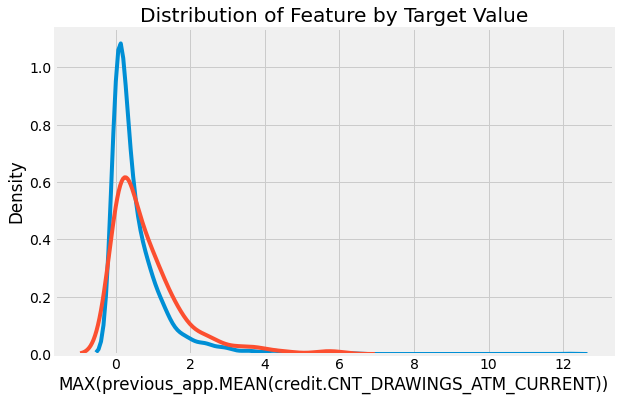

In [51]:
kde_target_plot(features_sample, feature = 'MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))')

In [53]:
threshold = 0.9 
correlated_pairs = {}
for col in correlations:
    corr_list = [val for val in list(correlations.index[correlations[col] > threshold]) if val != col]
    correlated_pairs[col] = corr_list

In [54]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))']

In [55]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head(10)

Variable
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                       1.000000
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    0.999382
MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.999024
MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995957
SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995484
SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))           0.967272
MEAN(credit.AMT_PAYMENT_CURRENT)                             0.964953
MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))           0.964779
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))          0.964681
MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))           0.963554
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

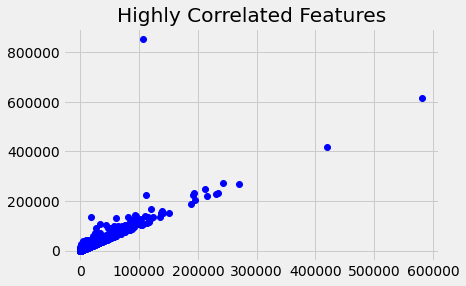

In [56]:
plt.plot(features_sample['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'], features_sample['MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))'], 'bo')
plt.title('Highly Correlated Features');

In [57]:
# Read in the feature importances and sort with the most important at the top
fi = pd.read_csv('downloads/spec_feature_importances_ohe.csv', index_col = 0)
fi = fi.sort_values('importance', ascending = False)
fi.head(15)

feature  importance
13                                       EXT_SOURCE_1       357.6
14                                       EXT_SOURCE_3       311.6
58                                       EXT_SOURCE_2       307.0
31                                         DAYS_BIRTH       228.6
55                                         AMT_CREDIT       204.4
91                                        AMT_ANNUITY       195.2
69                                      DAYS_EMPLOYED       150.2
10                                    AMT_GOODS_PRICE       144.2
186                           MAX(bureau.DAYS_CREDIT)       138.8
42                                    DAYS_ID_PUBLISH       122.8
115                   MAX(bureau.DAYS_CREDIT_ENDDATE)       121.8
62                                        OWN_CAR_AGE       104.0
518   SUM(previous_app.MIN(installments.AMT_PAYMENT))       101.8
196                     MAX(bureau.DAYS_ENDDATE_FACT)        99.6
669  MEAN(previous_app.MIN(installments.AMT_PAYMENT))        99.0

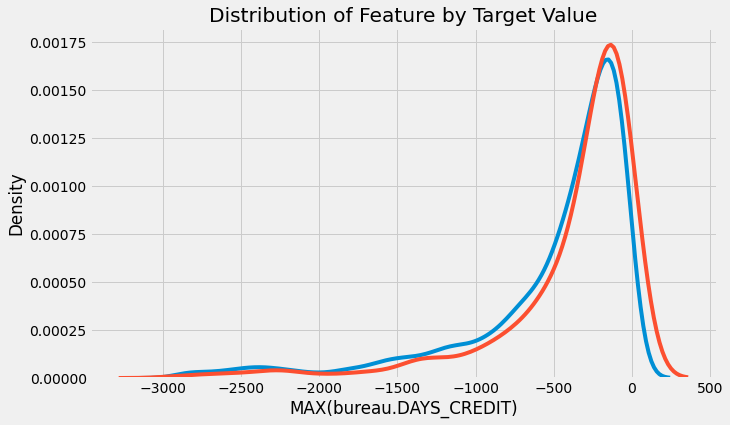

In [58]:
kde_target_plot(features_sample, feature = 'MAX(bureau.DAYS_CREDIT)')

In [59]:
# List of the original features (after one-hot)
original_features = list(pd.get_dummies(app).columns)

created_features = []

# Iterate through the top 100 features
for feature in fi['feature'][:100]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 100 features were made by featuretools' % len(created_features))

78 of the top 100 features were made by featuretools


In [60]:
plt.rcParams['font.size'] = 22

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Parameters
    --------
        df : dataframe
            feature importances. Must have the features in a column
            called `features` and the importances in a column called `importance
        
    Return
    -------
        shows a plot of the 15 most importance features
        
        df : dataframe
            feature importances sorted by importance (highest to lowest) 
            with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 10))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

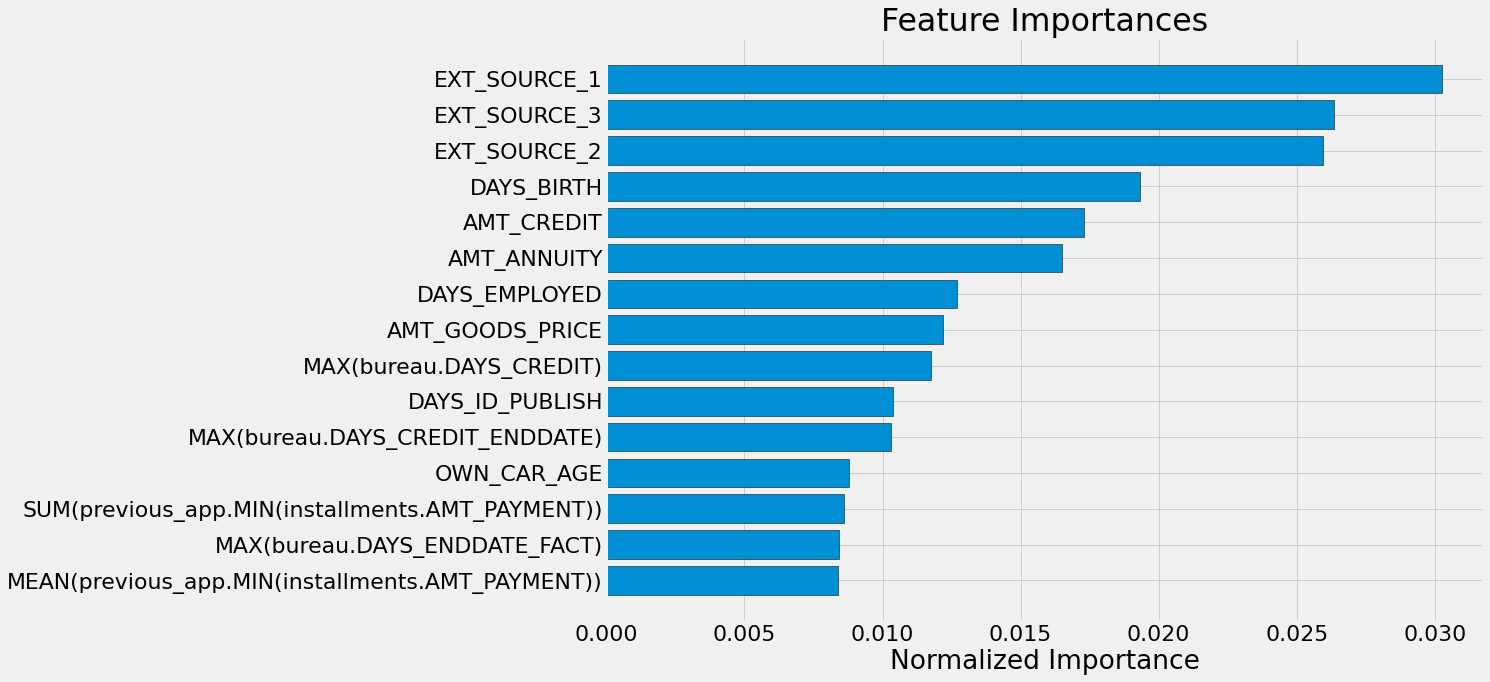

In [61]:
fi = plot_feature_importances(fi)

In [62]:
print('There are %d features with 0 importance' % sum(fi['importance'] == 0.0))

There are 237 features with 0 importance


In [64]:
from featuretools import selection
# Remove features with only one unique value
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('Removed %d features' % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

Removed 369 features


In [66]:
feature_matrix.shape

(2002, 2213)

In [65]:
# Separate out the train and test sets
train = feature_matrix2[feature_matrix2['set'] == 'train']
test = feature_matrix2[feature_matrix2['set'] == 'test']

# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Align dataframes on the columns
train, test = train.align(test, join = 'inner', axis = 1)
test = test.drop(columns = ['TARGET'])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (1001, 2156)
Final Testing Shape:  (1001, 2155)


# Tuning automated feature engineering

In [213]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('downloads/application_train.csv/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
app_test = pd.read_csv('downloads/application_test.csv/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
bureau = pd.read_csv('downloads/bureau.csv/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('downloads/bureau_balance.csv/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('downloads/POS_CASH_balance.csv/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('downloads/credit_card_balance.csv/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('downloads/previous_application.csv/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('downloads/installments_payments.csv/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

In [214]:

app_test.shape

(1001, 121)

In [215]:
app_train.shape

(1001, 122)

In [216]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

In [217]:
bureau['DAYS_CREDIT'].head()

0    -857
1    -909
2    -879
3   -1572
4    -559
Name: DAYS_CREDIT, dtype: int64

In [218]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date + pd.to_timedelta(-492,'D')

Timestamp('2014-08-27 00:00:00')

In [219]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()


DAYS_CREDIT DAYS_CREDIT_ENDDATE DAYS_ENDDATE_FACT DAYS_CREDIT_UPDATE
0   -857 days           -492 days         -553 days          -155 days
1   -909 days           -179 days         -877 days          -155 days
2   -879 days           -514 days         -544 days          -155 days
3  -1572 days          -1329 days        -1328 days          -155 days
4   -559 days            902 days               NaT            -6 days

In [220]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

In [221]:
bureau['bureau_credit_application_date'].head()

0   2013-08-27
1   2013-07-06
2   2013-08-05
3   2011-09-12
4   2014-06-21
Name: bureau_credit_application_date, dtype: datetime64[ns]

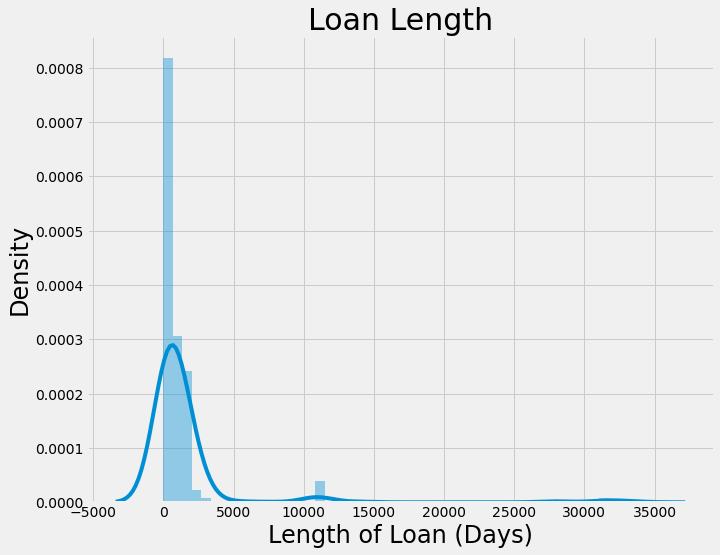

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

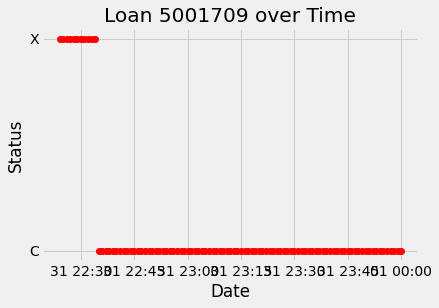

In [223]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'm')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

In [224]:
bureau_balance["STATUS"][0]

'C'

In [225]:
bureau_balance["bureau_balance_date"][0]

Timestamp('2015-12-31 23:53:00')

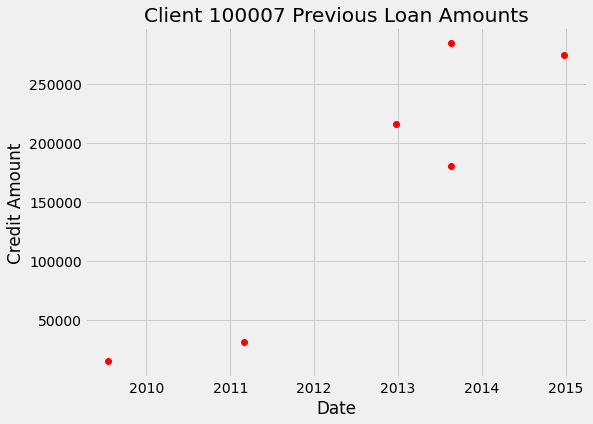

In [226]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

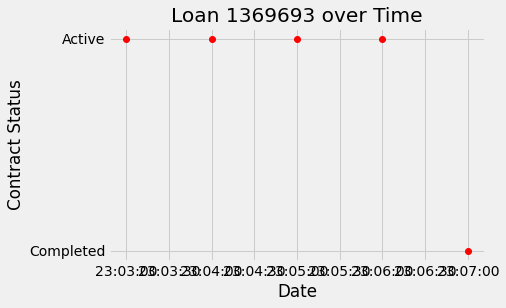

In [227]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'm')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'], 'm')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns = ['MONTHS_BALANCE'])

# Select on loan and plot
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');

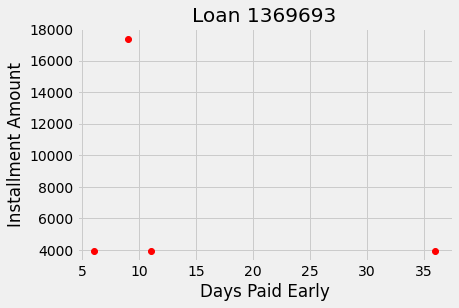

In [228]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

In [229]:
from woodwork.logical_types import Categorical, Ordinal,Boolean

In [230]:

# Iterate through the columns and record the Boolean columns
for col in app_train:
    # If column is a number with only two values, encode it as a Boolean
    if (app_train[col].dtype != 'object') and (len(app_train[col].unique()) <= 2):
        app_types[col] = Boolean

print('Number of boolean variables: ', len(app_types))

Number of boolean variables:  39


In [231]:
li = list(app_train["REGION_RATING_CLIENT"].unique())

li.sort()

In [232]:
li2 = list(app_train["REGION_RATING_CLIENT_W_CITY"].unique())

li2.sort()

In [233]:
# Record ordinal variables
app_types['REGION_RATING_CLIENT'] = Ordinal(order=li)
app_types['REGION_RATING_CLIENT_W_CITY'] = Ordinal(order=li2)

app_test_types = app_types.copy()
del app_test_types['TARGET']

In [234]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY':Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': Boolean}

In [211]:
es2 = ft.EntitySet(id="clients")

In [235]:
# Entities with a unique index
es2 = es2.add_dataframe(dataframe_name = 'app_train', dataframe = app_train, 
                              index = 'SK_ID_CURR', logical_types = app_types)

es2 = es2.add_dataframe(dataframe_name = 'app_test', dataframe = app_test, 
                              index = 'SK_ID_CURR', logical_types = app_test_types)

es2 = es2.add_dataframe(dataframe_name = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es2 = es2.add_dataframe(dataframe_name = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              logical_types = previous_types)

# Entities that do not have a unique index
es2 = es2.add_dataframe(dataframe_name = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es2 = es2.add_dataframe(dataframe_name = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es2 = es2.add_dataframe(dataframe_name = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es2 = es2.add_dataframe(dataframe_name = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')

In [236]:
# Relationship between app and bureau
r_app_bureau = es2.add_relationship('app_train','SK_ID_CURR', 'bureau','SK_ID_CURR')

# Test Relationship between app and bureau
r_test_app_bureau = es2.add_relationship('app_test','SK_ID_CURR', 'bureau','SK_ID_CURR')

# Relationship between bureau and bureau balance
r_bureau_balance = es2.add_relationship('bureau','SK_ID_BUREAU', 'bureau_balance','SK_ID_BUREAU')

# Relationship between current app and previous apps
r_app_previous = es2.add_relationship('app_train','SK_ID_CURR','previous','SK_ID_CURR')

# Test Relationship between current app and previous apps
r_test_app_previous = es2.add_relationship('app_test','SK_ID_CURR', 'previous','SK_ID_CURR')

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = es2.add_relationship('previous','SK_ID_PREV', 'cash','SK_ID_PREV')
r_previous_installments = es2.add_relationship('previous','SK_ID_PREV', 'installments','SK_ID_PREV')
r_previous_credit = es2.add_relationship('previous','SK_ID_PREV','credit','SK_ID_PREV')

# Print out the EntitySet
es2

Entityset: clients
  DataFrames:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [237]:
time_features, time_feature_names = ft.dfs(entityset = es2, target_dataframe_name = 'app_train', 
                                           trans_primitives = ['cum_sum', 'time_since_previous'], max_depth = 2,
                                           agg_primitives = ['trend'] ,
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_dataframes = ['app_test'])

Built 452 features
Elapsed: 00:17 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [238]:
time_features.iloc[:, -10:].head()

CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))  \
SK_ID_CURR                                                                     
100002                                                                   NaN   
100003                                                            367.444774   
100004                                                                   NaN   
100006                                                            630.070715   
100007                                                            762.957307   

            CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))  \
SK_ID_CURR                                                                
100002                                                              NaN   
100003                                                       418.305454   
100004                                                              NaN   
100006                                                       776.928357   
100007                                                       928.679814   

            CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))  \
SK_ID_CURR                                                                      
100002                                                                    NaN   
100003                                                                    NaN   
100004                                                                    NaN   
100006                                                                    NaN   
100007                                                                    NaN   

            CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))  \
SK_ID_CURR                                                                     
100002                                                                   NaN   
100003                                                            367.444774   
100004                                                                   NaN   
100006                                                           1391.162781   
100007                                                           1524.049373   

            CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))  \
SK_ID_CURR                                                                 
100002                                                               NaN   
100003                                                         -0.001774   
100004                                                               NaN   
100006                                                          0.045124   
100007                                                          0.055780   

            CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))  \
SK_ID_CURR                                                                             
100002                                                                           NaN   
100003                                                                     -0.000448   
100004                                                                           NaN   
100006                                                                      0.002063   
100007                                                                      0.000891   

            CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))  \
SK_ID_CURR                                                                       
100002                                                                     NaN   
100003                                                                     NaN   
100004                                                                     NaN   
100006                                                                     NaN   
100007                                                                     NaN   

            CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_deci

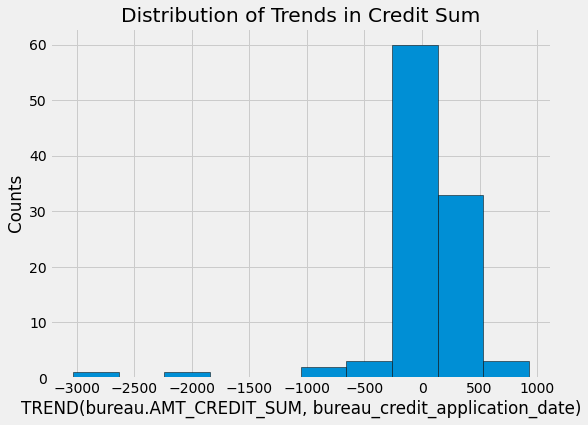

In [239]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Credit Sum');

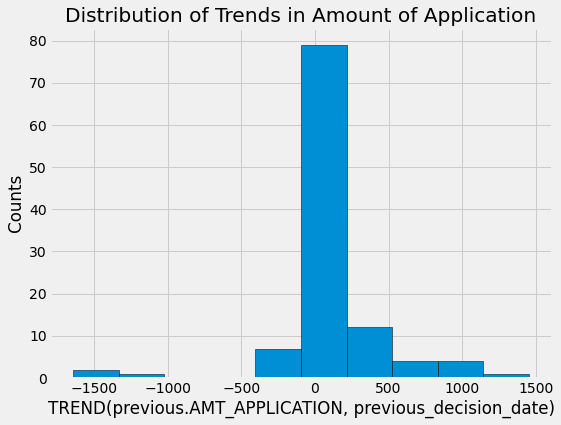

In [240]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Amount of Application');

In [241]:
time_feature_names[-10:]

[<Feature: CUM_SUM(TREND(previous.AMT_APPLICATION, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_CREDIT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.AMT_GOODS_PRICE, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.HOUR_APPR_PROCESS_START, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_DOWN_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIMARY, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(previous.SELLERPLACE_AREA, previous_decision_date))>]

In [242]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

In [243]:
values_dict = {'NAME_CONTRACT_STATUS':['Approved', 'Refused', 'Canceled']}
es2.add_interesting_values(dataframe_name='previous', values=values_dict)

In [244]:
interesting_features, interesting_feature_names = ft.dfs(entityset = es2, target_dataframe_name = 'app_train',
                                           where_primitives = ['mean', 'mode'],              
                                           trans_primitives = [], max_depth = 1,
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                                         
                                           ignore_dataframes = ['app_test'])

Built 355 features
Elapsed: 00:02 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [245]:
interesting_features.iloc[:, -6:, ].head()

MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Canceled)  \
SK_ID_CURR                                                                            
100002                                                                          NaN   
100003                                                                          NaN   
100004                                                                          NaN   
100006                                                                         Cash   
100007                                                                          NaN   

           MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Refused)  \
SK_ID_CURR                                                                           
100002                                                                         NaN   
100003                                                                         NaN   
100004                                                                         NaN   
100006                                                            Cash X-Sell: low   
100007                                                                         NaN   

           MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Approved)  \
SK_ID_CURR                                                                            
100002                                                      POS other with interest   
100003                                                             Cash X-Sell: low   
100004                                                  POS mobile without interest   
100006                                                                  Card X-Sell   
100007                                                          Cash X-Sell: middle   

           MODE(previous.WEEKDAY_APPR_PROCESS_START WHERE NAME_CONTRACT_STATUS = Canceled)  \
SK_ID_CURR                                                                                   
100002                                                                                 NaN   
100003                                                                                 NaN   
100004                                                                                 NaN   
100006                                                                            THURSDAY   
100007                                                                                 NaN   

           MODE(previous.WEEKDAY_APPR_PROCESS_START WHERE NAME_CONTRACT_STATUS = Refused)  \
SK_ID_CURR                                                                                  
100002                                                                                NaN   
100003                                                                                NaN   
100004                                                                                NaN   
100006                                                                           THURSDAY   
100007                                                                                NaN   

           MODE(previous.WEEKDAY_APPR_PROCESS_START WHERE NAME_CONTRACT_STATUS = Approved)  
SK_ID_CURR                                                                                  
100002                                                                            SATURDAY  
100003                                                                              FRIDAY  
100004                                                                              FRIDAY  
100006                                                                            THURSDAY  
100007                                                                              SUNDAY

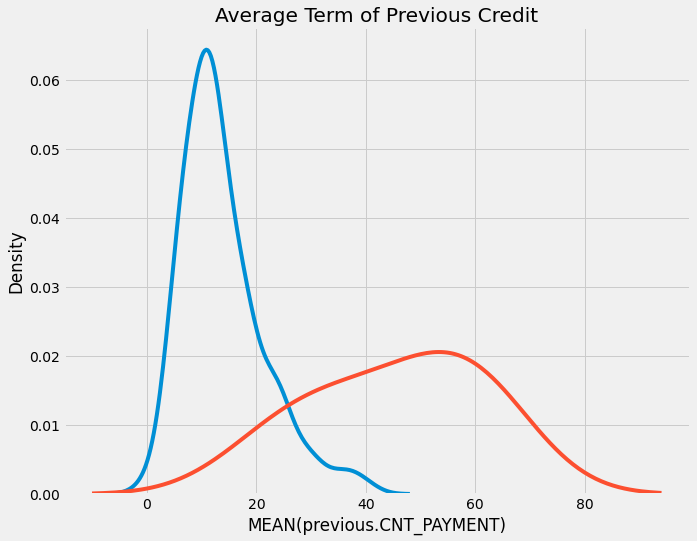

In [246]:
plt.figure(figsize = (10, 8))
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)'].dropna(), label = 'Approved')
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)'].dropna(), label = 'Canceled')
plt.xlabel('MEAN(previous.CNT_PAYMENT)'); plt.ylabel('Density'); plt.title('Average Term of Previous Credit');

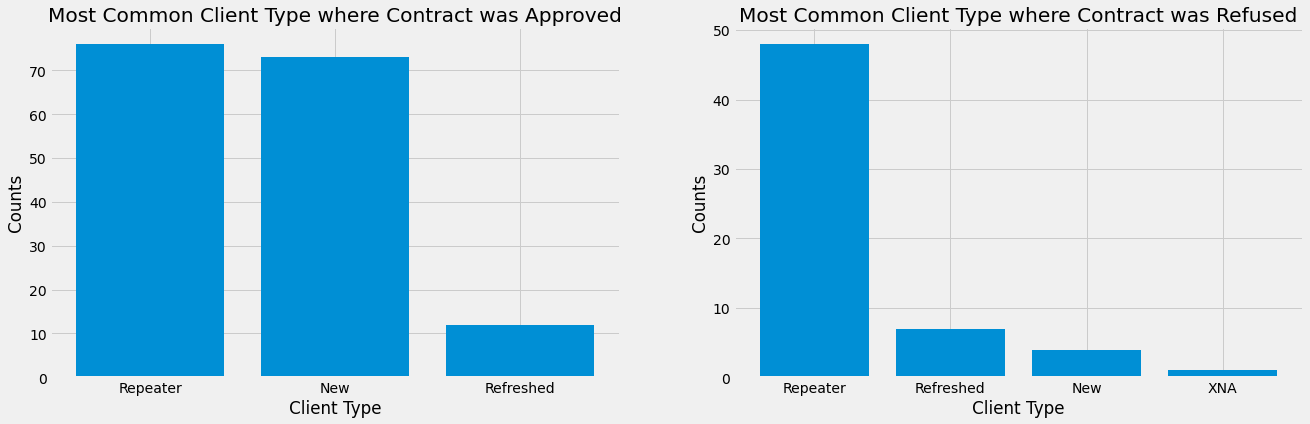

In [247]:
# Plot of client type when contract was approved
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.bar(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts())
plt.xticks(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Approved");

# Plot of client type where contract was refused
plt.subplot(1, 2, 2)
plt.bar(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts())
plt.xticks(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Refused");

In [248]:
# Late Payment seed feature
late_payment = ft.Feature(es2['installments'].ww['installments_due_date']) < ft.Feature(es2['installments'].ww['installments_paid_date'])

In [251]:
# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es2,
                                           target_dataframe_name = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_dataframes = ['app_test'])

Built 251 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [252]:
seed_features.iloc[:, -2:].head(10)

PERCENT_TRUE(credit.previous.NFLAG_LAST_APPL_IN_DAY)  \
SK_ID_CURR                                                         
100002                                                       0.0   
100003                                                       0.0   
100004                                                       0.0   
100006                                                       1.0   
100007                                                       0.0   
100008                                                       0.0   
100009                                                       0.0   
100010                                                       0.0   
100011                                                       1.0   
100012                                                       0.0   

            MEAN(previous.PERCENT_TRUE(installments.late_payment))  
SK_ID_CURR                                                          
100002                                                    0.000000  
100003                                                    0.000000  
100004                                                    0.000000  
100006                                                    0.000000  
100007                                                    0.239927  
100008                                                    0.018182  
100009                                                    0.000000  
100010                                                    0.000000  
100011                                                    0.207870  
100012                                                    0.089015

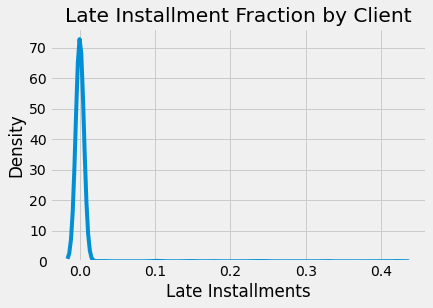

In [253]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client');

In [254]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es2['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

In [255]:
# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(entityset = es2,
                                           target_dataframe_name = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [past_due],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_dataframes = ['app_test'])

Built 251 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [286]:
from woodwork.logical_types import (
    Boolean, Datetime,
   Categorical,
    Timedelta,
    NaturalLanguage
)

from featuretools.primitives import AggregationPrimitive
from datetime import datetime, timedelta

from collections import Counter
from woodwork.column_schema import ColumnSchema

In [282]:
x = ["a","b","a"]
counts = dict(Counter(x))
counts

{'a': 2, 'b': 1}

In [343]:
class Normalized_Mode(AggregationPrimitive):
    
    name = 'normalized_mode_count'
    input_types = [ColumnSchema(logical_type=Categorical)]
    return_type = ColumnSchema(semantic_tags={'category'})
    
    def get_function(self):
        def normalized_mode_count(x):
            """
            Return the fraction of total observations that 
            are the most common observation. For example, 
            in an array of ['A', 'A', 'A', 'B', 'B'], the 
            function will return 0.6."""

            if x.mode().shape[0] == 0:
                return np.nan

            # Count occurence of each value
            counts = dict(Counter(x.values))
            # Find the mode
            mode = x.mode().iloc[0]
            # Divide the occurences of mode by the total occurrences
            return counts[mode] / np.sum(list(counts.values()))
        
        return normalized_mode_count


In [315]:
ft.list_semantic_tags()

name  is_standard_tag  \
0        numeric             True   
1       category             True   
2          index            False   
3     time_index            False   
4  date_of_birth            False   
5         ignore            False   
6    passthrough            False   

                                                             valid_logical_types  
0            [Age, AgeFractional, AgeNullable, Double, Integer, IntegerNullable]  
1   [Categorical, CountryCode, CurrencyCode, Ordinal, PostalCode, SubRegionCode]  
2                                                                Any LogicalType  
3  [Datetime, Age, AgeFractional, AgeNullable, Double, Integer, IntegerNullable]  
4                                                                     [Datetime]  
5                                                                Any LogicalType  
6                                                                Any LogicalType

In [321]:
class Longest_Seq(AggregationPrimitive):
    
    name = 'longest_repetition'    
    input_types = [ColumnSchema(logical_type=Categorical)]
    return_type = ColumnSchema(semantic_tags={'category'})
    
    def get_function(self):
        def longest_repetition(x):
            """
            Returns the item with most consecutive occurrences in `x`. 
            If there are multiple items with the same number of conseqcutive occurrences,
            it will return the first one. If `x` is empty, returns None. 
            """

            x = x.dropna()

            if x.shape[0] < 1:
                return None

            # Set the longest element
            longest_element = current_element = None
            longest_repeats = current_repeats = 0

            # Iterate through the iterable
            for element in x:
                if current_element == element:
                    current_repeats += 1
                else:
                    current_element = element
                    current_repeats = 1
                if current_repeats > longest_repeats:
                    longest_repeats = current_repeats
                    longest_element = current_element

            return longest_element
        
        return longest_repetition
 

In [322]:
# DFS with custom features
custom_features, custom_feature_names = ft.dfs(entityset = es2,
                                              target_dataframe_name = 'app_train',
                                              agg_primitives = [Normalized_Mode, Longest_Seq],
                                              max_depth = 2,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_dataframes = ['app_test'])

custom_features.iloc[:, -40:].head()

Built 267 features
Elapsed: 00:03 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


NORMALIZED_MODE_COUNT(installments.previous.NAME_PAYMENT_TYPE)  \
SK_ID_CURR                                                                   
100002                                                             1.00000   
100003                                                             0.72000   
100004                                                             1.00000   
100006                                                             0.68750   
100007                                                             0.80303   

            NORMALIZED_MODE_COUNT(installments.previous.NAME_PORTFOLIO)  \
SK_ID_CURR                                                                
100002                                                         1.000000   
100003                                                         0.720000   
100004                                                         1.000000   
100006                                                         0.937500   
100007                                                         0.636364   

            NORMALIZED_MODE_COUNT(installments.previous.NAME_PRODUCT_TYPE)  \
SK_ID_CURR                                                                   
100002                                                            1.000000   
100003                                                            0.720000   
100004                                                            1.000000   
100006                                                            0.937500   
100007                                                            0.378788   

            NORMALIZED_MODE_COUNT(installments.previous.NAME_SELLER_INDUSTRY)  \
SK_ID_CURR                                                                      
100002                                                               1.000000   
100003                                                               0.480000   
100004                                                               1.000000   
100006                                                               0.625000   
100007                                                               0.606061   

            NORMALIZED_MODE_COUNT(installments.previous.NAME_TYPE_SUITE)  \
SK_ID_CURR                                                                 
100002                                                               NaN   
100003                                                          0.720000   
100004                                                          1.000000   
100006                                                          0.625000   
100007                                                          0.469697   

            NORMALIZED_MODE_COUNT(installments.previous.NAME_YIELD_GROUP)  \
SK_ID_CURR                                                                  
100002                                                           1.000000   
100003                                                           0.720000   
100004                                                           1.000000   
100006                                                           0.625000   
100007                                                           0.621212   

            NORMALIZED_MODE_COUNT(installments.previous.PRODUCT_COMBINATION)  \
SK_ID_CURR                                                                     
100002                                                              1.000000   
100003                                                              0.480000   
100004                                                              1.000000   
100006                                                              0.625000   
100007                                                              0.378788   

            NORMALIZED_MODE_COUNT(installments.previous.WEEKDAY_APPR_PROCESS_START)  \
SK_ID_CURR                                                                            
100002          

In [320]:
bureau.CREDIT_ACTIVE.head()

6238780    Closed
6494755    Closed
5680687    Closed
6403250    Closed
5506318    Closed
Name: CREDIT_ACTIVE, dtype: category
Categories (3, object): ['Active', 'Closed', 'Sold']

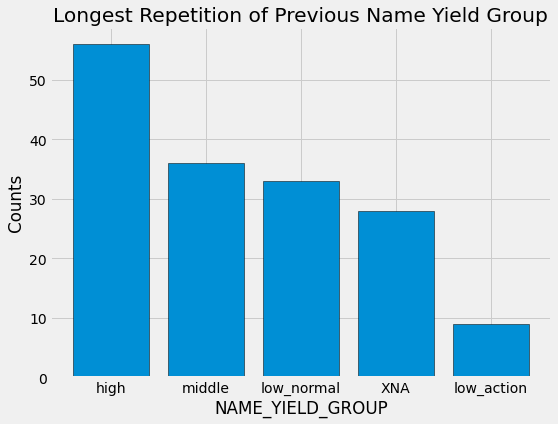

In [323]:
plt.figure(figsize = (8, 6))
plt.bar(custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts().index, custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts(), edgecolor = 'k')
plt.xlabel('NAME_YIELD_GROUP'); plt.ylabel('Counts'); plt.title('Longest Repetition of Previous Name Yield Group');

<AxesSubplot:xlabel='NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)', ylabel='Density'>

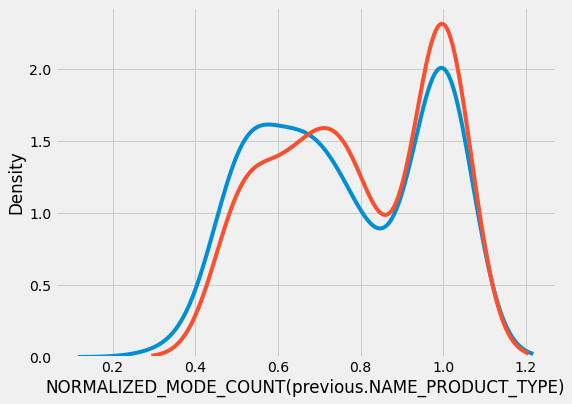

In [324]:
plt.figure(figsize = (8, 6))
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)'], label = 'NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)')
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)'], label = 'NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)')

In [326]:
custom_features.iloc[0]["TARGET"]

True

In [330]:
class Most_Rec(AggregationPrimitive):
    
    name = 'most_recent'    
    input_types = [ColumnSchema(logical_type=Categorical),ColumnSchema(logical_type=Categorical)]
    return_type = ColumnSchema(semantic_tags={'category'})
    
    def get_function(self):
        
        def most_recent(y, x):
            df = pd.DataFrame({"x": x, "y": y}).dropna()

            if df.shape[0] < 1:
                return np.nan

            # Sort the values by timestamps reversed
            df = df.sort_values('x', ascending = False).reset_index()

            # Return the most recent occurence
            return df.iloc[0]['y']
        
        return most_recent


In [331]:
# DFS with custom feature 2
custom_features2, custom_feature_names2 = ft.dfs(entityset = es2,
                                              target_dataframe_name = 'app_train',
                                              agg_primitives = ['last', Most_Rec],
                                               max_depth = 1,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_dataframes = ['app_test'])

Built 409 features
Elapsed: 00:56 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [334]:
custom_features2.iloc[:,-40:].head()

MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_CONTRACT_STATUS)  \
SK_ID_CURR                                                                
100002                                                       low_normal   
100003                                                           middle   
100004                                                           middle   
100006                                                       low_normal   
100007                                                             high   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_CONTRACT_TYPE)  \
SK_ID_CURR                                                              
100002                                                     low_normal   
100003                                                         middle   
100004                                                         middle   
100006                                                            XNA   
100007                                                           high   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_GOODS_CATEGORY)  \
SK_ID_CURR                                                               
100002                                                      low_normal   
100003                                                      low_normal   
100004                                                          middle   
100006                                                            high   
100007                                                          middle   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_PAYMENT_TYPE)  \
SK_ID_CURR                                                             
100002                                                    low_normal   
100003                                                    low_normal   
100004                                                        middle   
100006                                                        middle   
100007                                                        middle   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_PORTFOLIO)  \
SK_ID_CURR                                                          
100002                                                 low_normal   
100003                                                     middle   
100004                                                     middle   
100006                                                        XNA   
100007                                                       high   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_PRODUCT_TYPE)  \
SK_ID_CURR                                                             
100002                                                    low_normal   
100003                                                    low_normal   
100004                                                        middle   
100006                                                          high   
100007                                                        middle   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_SELLER_INDUSTRY)  \
SK_ID_CURR                                                                
100002                                                       low_normal   
100003                                                       low_normal   
100004                                                           middle   
100006                                                             high   
100007                                                           middle   

           MOST_RECENT(previous.NAME_YIELD_GROUP, NAME_TYPE_SUITE)  \
SK_ID_CURR                                                           
100002                                                         NaN   
100003                                                  low_normal   
100004                                                      middle   
100006                                                         XNA   
100007        

In [344]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es2, target_dataframe_name = 'app_train',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', Normalized_Mode, Longest_Seq, Most_Rec],
                                       trans_primitives = ['diff', 'time_since_previous' , 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True,
                                       chunk_size = len(app_train),
                                       ignore_dataframes = ['app_test'])

Built 4949 features
Elapsed: 03:21 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [345]:
# Run and create the features
feature_matrix_test, feature_names_test = ft.dfs(entityset = es2, target_dataframe_name = 'app_test',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', Normalized_Mode, Longest_Seq, Most_Rec],
                                       trans_primitives = ['diff', 'time_since_previous', 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True,
                                       chunk_size = len(app_train),
                                       ignore_dataframes = ['app_train'])

Built 4948 features
Elapsed: 01:38 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [346]:
import random
random.sample(feature_names, 10)

[<Feature: TREND(cash.SK_DPD, cash_balance_date)>,
 <Feature: MIN(previous.MAX(credit.AMT_PAYMENT_TOTAL_CURRENT))>,
 <Feature: SUM(previous.MAX(cash.SK_DPD_DEF) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: SUM(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: DIFF(SUM(bureau.AMT_CREDIT_SUM_OVERDUE))>,
 <Feature: MOST_RECENT(installments.previous.NAME_YIELD_GROUP, previous.NAME_PAYMENT_TYPE)>,
 <Feature: MOST_RECENT(credit.previous.NAME_PORTFOLIO, previous.NAME_YIELD_GROUP)>,
 <Feature: DIFF(MIN(credit.AMT_PAYMENT_CURRENT))>,
 <Feature: MIN(previous.TREND(credit.AMT_INST_MIN_REGULARITY, credit_balance_date))>,
 <Feature: MEAN(bureau.AMT_CREDIT_SUM_OVERDUE)>]

In [347]:
from featuretools import selection

# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))

Removed 1067 features from training features
Removed 1115 features from testing features


In [349]:
set(feature_matrix) - set(feature_matrix2)

{'MEAN(previous.MEAN(credit.SK_DPD) WHERE NAME_CONTRACT_STATUS = Canceled)',
 'SUM(previous.MEAN(credit.AMT_DRAWINGS_OTHER_CURRENT) WHERE NAME_CONTRACT_STATUS = Refused)',
 'MEAN(previous.MIN(credit.CNT_DRAWINGS_POS_CURRENT) WHERE NAME_CONTRACT_STATUS = Canceled)',
 'NORMALIZED_MODE_COUNT(bureau.MODE(bureau_balance.STATUS))',
 'MEAN(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT) WHERE NAME_CONTRACT_STATUS = Canceled)',
 'TREND(previous.MIN(credit.SK_DPD), previous_decision_date)',
 'SUM(previous.MAX(cash.SK_DPD) WHERE NAME_CONTRACT_STATUS = Refused)',
 'MEAN(previous.MAX(credit.AMT_BALANCE) WHERE NAME_CONTRACT_STATUS = Canceled)',
 'TREND(previous.MEAN(credit.CNT_DRAWINGS_CURRENT), previous_decision_date)',
 'MEAN(previous.MAX(cash.SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Refused)',
 'MEAN(installments.previous.AMT_APPLICATION WHERE previous.NAME_CONTRACT_STATUS = Canceled)',
 'TREND(previous.MIN(credit.AMT_RECEIVABLE_PRINCIPAL), previous_decision_date)',
 'SUM(previous.MIN(credit.CNT

In [351]:
feature_matrix3 = selection.remove_highly_correlated_features(feature_matrix2)
print('Removed %d features from training features'  % (feature_matrix2.shape[1] - feature_matrix3.shape[1]))
feature_matrix_test3 = selection.remove_highly_correlated_features(feature_matrix_test2)
print('Removed %d features from testing features' % (feature_matrix_test2.shape[1] - feature_matrix_test3.shape[1]))

Removed 2107 features from training features
Removed 1960 features from testing features


In [352]:
feature_matrix3.shape

(1001, 1775)

In [353]:
feature_matrix2.shape

(1001, 3882)

In [354]:
train_labels = feature_matrix['TARGET']
feature_matrix_final, feature_matrix_test_final = feature_matrix3.align(feature_matrix_test3, join = 'inner', axis = 1)
feature_matrix_final['TARGET'] = train_labels

print('Final training shape: ', feature_matrix_final.shape)
print('Final testing shape: ', feature_matrix_test_final.shape)

Final training shape:  (1001, 1636)
Final testing shape:  (1001, 1635)


In [355]:
# Save the feature matrix to a csv
feature_matrix_final.to_csv('feature_matrix.csv')
feature_matrix_test_final.to_csv('feature_matrix_test.csv')